Fit Sornette Oscillations to Stock Historical Data

C:\Users\Spark\AppData\Local\Temp\ipykernel_3596\3746901121.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Close/Last'] = data['Close/Last'].str.replace('$', '').astype(float)


Initial Guess:  [17.75047619047619, -0.04765598567359134, 0.8, 0.5, 6, 0, 35]
Bounds:  ([14.200380952380952, -0.4765598567359134, 0, 0.1, 2, -3.141592653589793, 21], [21.300571428571427, 0, 1, 1, 12, 3.141592653589793, 49])
Optimized Parameters:  [18.30477692 -0.47655986  1.          0.10870287  4.40217346  3.14159265
 32.91560373]
LPPL Values:  [16.98903784 17.04280851 17.10965155 ... 18.15315326 18.15315326
 18.15315326]


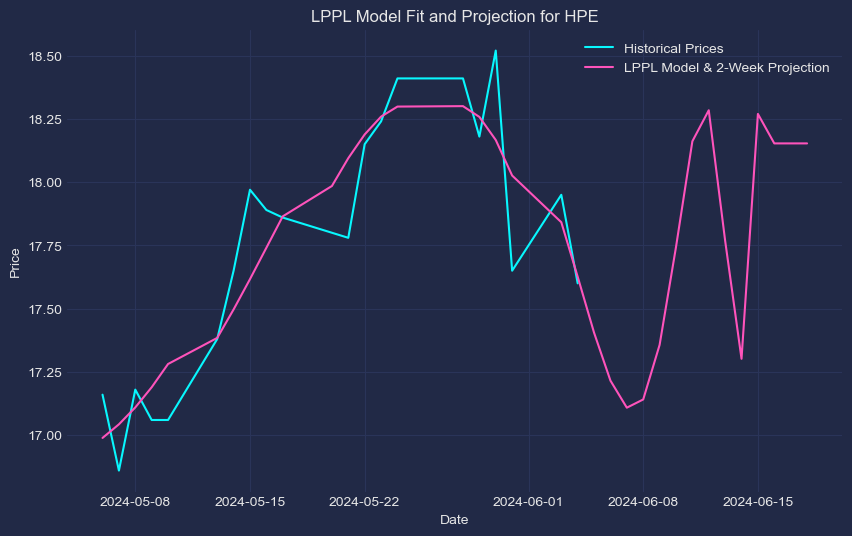

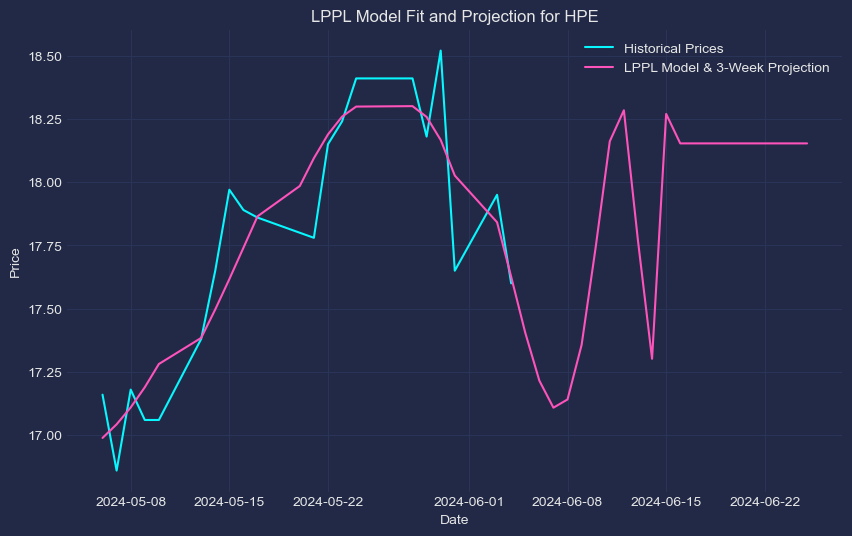

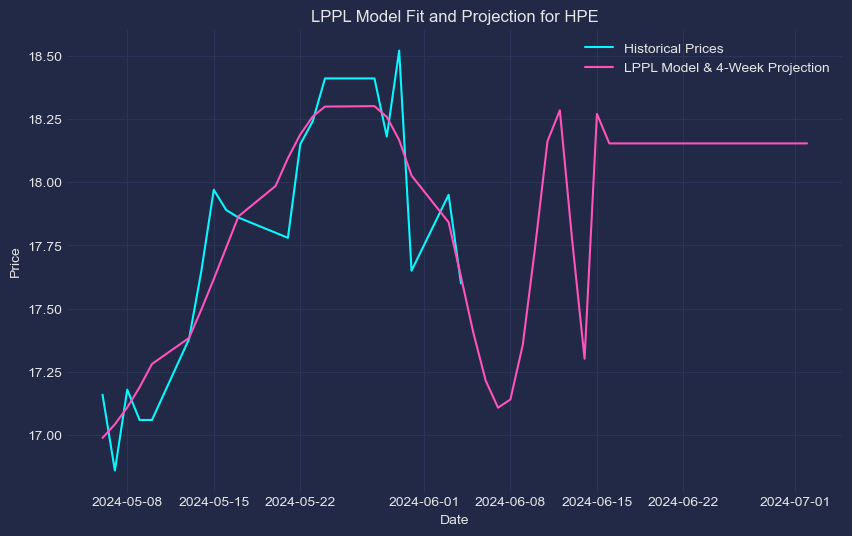

In [27]:
#From CSV iterate projection model to generate 2, 3 4 week projections.
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import mplcyberpunk

plt.style.use("cyberpunk")


# Load the CSV file
file_path = 'F:/inputs/stocks/HPE.csv'
data = pd.read_csv(file_path)

# Data preparation
data['Date'] = pd.to_datetime(data['Date'])
data['Close/Last'] = data['Close/Last'].str.replace('$', '').astype(float)
data.sort_values('Date', inplace=True)

# Define the LPPL function with better handling for small values
def lppl(t, A, B, C, m, omega, phi, t_c):
    with np.errstate(divide='ignore', invalid='ignore'):
        value = A + B * np.power(np.maximum(t_c - t, 1e-6), m) * (1 + C * np.cos(omega * np.log(np.maximum(t_c - t, 1e-6)) + phi))
        return np.nan_to_num(value, nan=0.0, posinf=0.0, neginf=0.0)

# Debugging output: Check the initial guess and bounds
print("Initial Guess: ", initial_guess)
print("Bounds: ", bounds)

# Fit the LPPL model with constrained optimization
try:
    popt, pcov = curve_fit(lppl, time_points, prices, p0=initial_guess, bounds=bounds, maxfev=10000)
    print("Optimized Parameters: ", popt)
except RuntimeError as e:
    print("Curve fitting failed: ", e)

# Ensure the LPPL values are sensible
lppl_values = lppl(np.arange(1, len(data) + 29), *popt)
print("LPPL Values: ", lppl_values)

# Projection window setup (4 weeks)
projection_days = 28
future_dates = pd.date_range(data['Date'].iloc[-1], periods=projection_days + 1, freq='D')[1:]
all_dates = pd.concat([data['Date'], pd.Series(future_dates)], ignore_index=True)

# Ensure the lengths match
assert len(all_dates) == len(lppl_values), f"Mismatch in lengths of dates and LPPL values: {len(all_dates)} != {len(lppl_values)}"

# Filter data for the most recent month
most_recent_date = data['Date'].max()
one_month_ago = most_recent_date - pd.DateOffset(months=1)
recent_data = data[data['Date'] > one_month_ago]

# Normalize the time points and prices for the recent data
time_points = np.arange(1, len(recent_data) + 1)
prices = recent_data['Close/Last'].values

# Adjust initial guess based on the recent data range
initial_guess = [np.mean(prices), -np.std(prices) * 0.1, 0.8, 0.5, 6, 0, len(recent_data) + 14]

# Refine bounds to ensure realistic parameter constraints
bounds = ([np.mean(prices) * 0.8, -np.std(prices), 0, 0.1, 2, -np.pi, len(recent_data)],
          [np.mean(prices) * 1.2, 0, 1, 1, 12, np.pi, len(recent_data) + 28])

# Fit the LPPL model with constrained optimization
popt, pcov = curve_fit(lppl, time_points, prices, p0=initial_guess, bounds=bounds, maxfev=10000)

# Define function to plot projections
def plot_projections(projection_weeks):
    projection_days = projection_weeks * 7
    projection_range = np.arange(1, len(recent_data) + projection_days + 1)
    lppl_values = lppl(projection_range, *popt)

    future_dates = pd.date_range(recent_data['Date'].iloc[-1], periods=projection_days + 1, freq='D')[1:]
    all_dates = pd.concat([recent_data['Date'], pd.Series(future_dates)], ignore_index=True)

    plt.figure(figsize=(10, 6))
    plt.plot(recent_data['Date'], prices, label='Historical Prices')
    plt.plot(all_dates, lppl_values, label=f'LPPL Model & {projection_weeks}-Week Projection')
    plt.title('LPPL Model Fit and Projection for HPE')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot projections for 2, 3, and 4 weeks
plot_projections(2)
plot_projections(3)
plot_projections(4)


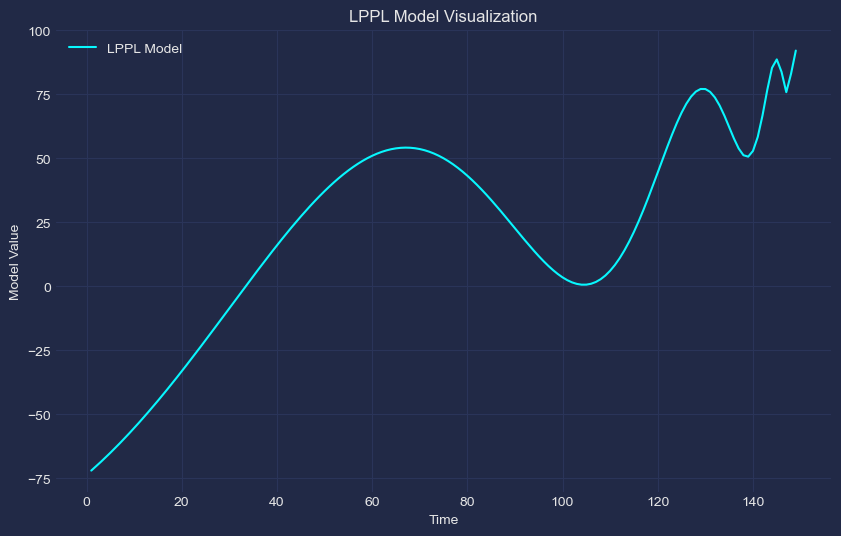

In [8]:
#LPPL model baseline
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk

plt.style.use("cyberpunk")

# Re-defining the LPPL function as the execution state was reset
def lppl(t, A, B, C, m, omega, phi, t_c):
    return A + B * np.power(t_c - t, m) * (1 + C * np.cos(omega * np.log(t_c - t) + phi))

# Parameters
A = 100
B = -10
C = 0.5
m = 0.5
omega = 4.5
phi = 2
t_c = 150

# Time points (for example, days)
time_points = np.arange(1, t_c)

# Apply the LPPL function to each time point
lppl_values = [lppl(t, A, B, C, m, omega, phi, t_c) for t in time_points]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_points, lppl_values, label='LPPL Model')
plt.title('LPPL Model Visualization')
plt.xlabel('Time')
plt.ylabel('Model Value')
plt.grid(True)
plt.legend()
plt.show()
